Create a new Markdown cell and answer: Above we mentioned that convolutional
filters are applied to local image regions, with weights shared across regions.
How does this compare to fully-connected neural networks?

Answer: TBD

In [211]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import autograd
import torch.nn.functional as F

#Prepare the data.
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
from numpy import linalg as LA

dtype = torch.FloatTensor

images = np.load("./data/images.npy")
labels = np.load("./data/labels.npy")

images = np.reshape(images, (images.shape[0], images.shape[1] * images.shape[2]))

images = images - images.mean()
images = images/images.std() 

train_seqs = images[0:40000]
val_seqs = images[40000:50000]

train_labels = labels[0:40000]
cv_labels = labels[40000:50000]

In [212]:
HEIGHT, WIDTH, NUM_CLASSES, NUM_OPT_STEPS = 26, 26, 5, 5000
learning_rate = 0.01

class TooSimpleConvNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 3x3 convolution that takes in an image with one channel
        # and outputs an image with 8 channels.
        self.conv1 = torch.nn.Conv2d(1, 8, kernel_size=3)
        # 3x3 convolution that takes in an image with 8 channels
        # and outputs an image with 16 channels. The output image
        # has approximately half the height and half the width
        # because of the stride of 2.
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=3, stride=2)
        # 1x1 convolution that takes in an image with 16 channels and
        # produces an image with 5 channels. Here, the 5 channels
        # will correspond to class scores.
        self.final_conv = torch.nn.Conv2d(16, 5, kernel_size=1)
    
    def forward(self, x):
        # Convolutions work with images of shape
        # [batch_size, num_channels, height, width]
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        return x
        

In [213]:
model = TooSimpleConvNN()

In [214]:
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

In [215]:
def train(batch_size):
    model.train()
    
    i = np.random.choice(train_seqs.shape[0], size = batch_size, replace=False)
    x = Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = Variable(torch.from_numpy(train_labels[i].astype(np.int)))
    
    optimizer.zero_grad()
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    loss.backward()
    optimizer.step()
    
    return loss.data[0]

In [216]:
def accuracy(y, y_hat):
    count = 0
    for i in range(y.shape[0]):
        if y[i] == y_hat[i]:
            count += 1
    return count/y.shape[0]

In [217]:
import random
def approx_train_accuracy():
    i = np.random.choice(train_seqs.shape[0], size = 1000, replace=False)
    x = Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = train_labels[i].astype(np.int)
    
    output = model(x)
    y_hat = np.argmax(output.data.numpy(), axis =1)
    acc = accuracy(y,y_hat)
    return acc

def val_accuracy():
    i = np.random.choice(val_seqs.shape[0], size = 1000, replace=False)
    x = Variable(torch.from_numpy(val_seqs[i].astype(np.float32)))
    y = cv_labels[i].astype(np.int) 
    
    output = model(x)
    y_hat = np.argmax(output.data.numpy(), axis =1)
    acc = accuracy(y,y_hat)

    return acc

In [218]:
for m in model.children():
    m.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
train_accs, val_accs = [], []
batch_size = 10
for i in range(2000):
    l = train(batch_size)
    if i % 100 == 0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

     0  0.20  0.20
   100  0.24  0.24
   200  0.53  0.51
   300  0.54  0.51
   400  0.52  0.50
   500  0.58  0.56
   600  0.56  0.56
   700  0.60  0.58
   800  0.62  0.64
   900  0.56  0.55
  1000  0.63  0.62
  1100  0.59  0.58
  1200  0.53  0.54
  1300  0.63  0.63
  1400  0.64  0.65
  1500  0.63  0.62
  1600  0.65  0.63
  1700  0.63  0.64
  1800  0.63  0.59
  1900  0.65  0.64


max_train accuracy:  0.653
max_val accuracy:  0.653


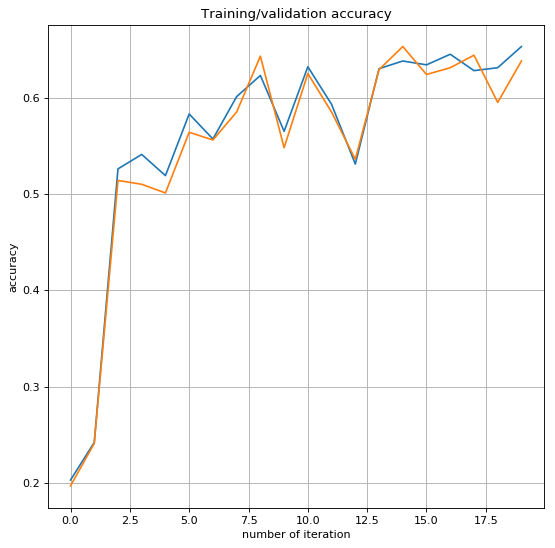

In [ ]:
import matplotlib.pyplot as plt


t = np.arange(0,len(train_accs),1)

s = train_accs
k = val_accs
print("max_train accuracy: ", max(train_accs))
print("max_val accuracy: ", max(val_accs))
plt.figure(figsize=(8,8), dpi = 80)
plt.plot(t, s, t, k)

plt.xlabel('number of iteration')
plt.ylabel('accuracy')
plt.title('Training/validation accuracy')
plt.grid(True)
plt.show()

In [ ]:
for m in model.children():
    m.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.05)
train_accs, val_accs = [], []
batch_size = 300
for i in range(5000):
    l = train(batch_size)
    if i % 100 == 0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

     0  0.17  0.19
   100  0.70  0.72
   200  0.72  0.75
   300  0.78  0.78
   400  0.81  0.81
   500  0.77  0.80


In [ ]:
t = np.arange(0,len(train_accs),1)

s = train_accs
k = val_accs
print("max_train accuracy: ", max(train_accs))
print("max_val accuracy: ", max(val_accs))
plt.figure(figsize=(8,8), dpi = 80)
plt.plot(t, s, t, k)

plt.xlabel('number of iteration')
plt.ylabel('accuracy')
plt.title('Training/validation accuracy')
plt.grid(True)
plt.show()